In [1]:
%load_ext autoreload
%autoreload 2

import sys
import json
sys.path.append('code/')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import os, binascii, hashlib, base58

from parse_config import ConfigDict
from balances import Balances
from simulation import Simulation

pd.set_option('display.max_rows', 20)

config = ConfigDict().parse()

def print_params(params):
    for k,v in params().items():
        print("{}: {}".format(k,v))

## No initial issuance

In [2]:
b = Balances(**config['default'])
print_params(b.params)
print("\nGini Coefficient: {:0.2f}".format(b.gini()))
b.data.head()

n_users: 10000
n_miners_max: 100
init_issue: False
reward_dist: False
reward: 100.0
greed_factor: 0.0

Gini Coefficient: 0.00


,address,greedy,miner,values
0,5KEDurYQ7PBUfRFpWyuVdkxPvXKAYiQGdePmArn9sD8vzL...,False,False,0.0
1,5JPvPsb6ZTLzRH9j81r6GRiC2Qf5Fnz8ruhgRTip75ZtgD...,False,False,0.0
2,5HredopLX975rSviybYDJQEpH661gTjdpFDjwYzj7r149v...,False,False,0.0
3,5Jj4yHYqoro2saTET5F2EuNu3KWj3yycdaKmSwvvZWdtf5...,False,False,0.0
4,5Jk3zDUArbGFBddqFCuv3Bb1LAqwQftx11idhfpneSNVGs...,False,False,0.0


## Fair initial issuance

In [3]:
b = Balances(**config['init_issue_fair_greedy'])
print_params(b.params)
print("\nGini Coefficient: {:0.2f}".format(b.gini()))
b.data.head()

n_users: 10000
n_miners_max: 100
init_issue: True
reward_dist: False
reward: 100.0
greed_factor: 0.05
init_issue_total: 1000000.0
init_issue_max: 500.0
init_issue_users: 9900

Gini Coefficient: 0.49


,address,greedy,miner,values
0,5JsDyLKpbeLGv6C4q7F57BKn7pgDvnMueXTfMrzUKSmZCp...,False,False,45.736342
1,5KZTaHo9xtnELWYhKAoL4F5FKUd1wxZ21S6LP1QPn16L9j...,False,False,104.444393
2,5KQb6huHo1anjyK4Le4NLZuydY3A9FZKN2TvoJjtosCe4W...,False,False,98.043808
3,5Hphf2dbF8oq1cnFUXNkGrszjEosZFGRUwiuSwjvhgjEoZ...,False,False,96.957623
4,5KjNSCJ8ExqMp7d7pMpYgCmrSai3sYpqqWNtAw8kHVSQF3...,False,False,49.381995


## Real initial issuance

In [4]:
b = Balances(**config['init_issue_real_greedy'])
print_params(b.params)
print("\nGini Coefficient: {:0.2f}".format(b.gini()))
b.data.head()

n_users: 10000
n_miners_max: 100
init_issue: True
reward_dist: False
reward: 100.0
greed_factor: 0.05
init_issue_total: 1000000.0
init_issue_max: 50000.0
init_issue_users: 1000

Gini Coefficient: 0.95


,address,greedy,miner,values
0,5JAHjxtFzZdgarZMzKW5UEwJGuuB8n6JHpsjYS9Rcowj1u...,False,False,230.900982
1,5Jx7BFcSf8vgCazgpxJtwHnb5uwB8SZsJLecUF9nGuJdD4...,False,False,0.000000
2,5JPPCzPJrMmwmNMhmiN4cawfSzwPkgni1hYtzL6zMRrzvx...,False,False,0.000000
3,5JxPb9bdWn78mZkFUgxG6Y96mAD1UoDU3Tt3Lbzt67kejc...,False,False,0.000000
4,5J6UdMpfaLxHECKNQVXuUpseosKqhTA9zprtwPSjpPFuKA...,False,False,0.000000


## Simulation experiments on greed

In [5]:
config = ConfigDict().parse()
init_states = { 'default': "No initial issuance",
                'init_issue_dist': "Distributed initial issuance",
                'init_issue_conc': "Concentrated initial issuance" }
greed_factor = { 'greedy': 0.05,
                 'no_greed': 0, }

exps = []
g_init = []
data = {}
g_all = {}

for init_key in init_states.keys():
    s = Simulation(balances = Balances(**config[init_key]), **config[init_key])
    g_init.append(s.balances.gini(initial=True) 

    for greed_key in greed_factor.keys():
        exp_key = '{}_{}'.format(init_key, greed_key)
        exps.append(exp_key)
        s.balances.greed_factor = greed_factor[greed_key]
        s.balances.reinit()

        # print_params(s.balances.params)
        # print_params(s.params)
        
        (tx_data, g) = s.simulate()
        
        data[exp_key] = tx_data
        g_all[exp_key] = g.copy()

    
    print("{}\t\t{:.5f}\t\t{:.5f}\t\t{:.5f}".format(init_states[init_key], 
                                                    s.balances.gini(initial=True), 
                                                    np.mean(g_all['{}_greedy'.format(init_key)]), 
                                                    np.mean(g_all['{}_no_greed'.format(init_key)])))


No initial issuance		0.00000		0.56037		0.13655
Distributed initial issuance		0.48740		0.54690		0.15993
Concentrated initial issuance		0.94846		0.54622		0.15950


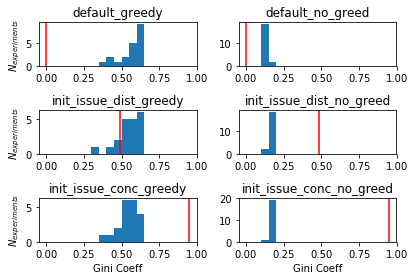

In [19]:
# histograms of simulation results
plt.close()
fig, axs = plt.subplots(3,2)
g_init = [ 0.0, 0.48740, 0.94846]

for ax_row, g_i, init_key in zip(axs, g_init, init_states.keys()):
    ax_row[0].set_ylabel(r'$N_{experiments}$')
    for ax, greed_key in zip(ax_row, greed_factor.keys()):
        exp = '{}_{}'.format(init_key, greed_key)
        ax.hist(g_all[exp], bins=np.arange(0.,1.,0.05))
        ax.set_title(exp)
        ax.axvline(x=g_i, color='r')
        
# xlabels
for ax in axs[2]:
    ax.set_xlabel('Gini Coeff')
    
plt.tight_layout()
plt.show()